In [1]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models

In [2]:
config = helper.Config("./simulations")

[INFO]
num_nodes = 1
gpu_per_node = 1
num_workers = 8

[DATA]
dataset = MNIST
n_views = 10
augmentations = GaussianBlur
blur_kernel_size = 3

[SSL]
backbone = resnet34
embedded_dim = 2
optimizer = SGD
use_projection_header = yes
proj_dim = 8
lr = 0.0005
momentum = 0.99
loss_function = EllipsoidPackingLoss
lw0 = 1.0
lw1 = 1.0
lw2 = 1.0
n_epochs = 3
batch_size = 128

[LC]
output_dim = 10
optimizer = SGD
weight_decay = 0.1
use_batch_norm = yes
lr = 0.01
momentum = 0.99
loss_function = CrossEntropyLoss
n_epochs = 3
batch_size = 128

[IO]
mode = new



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


468


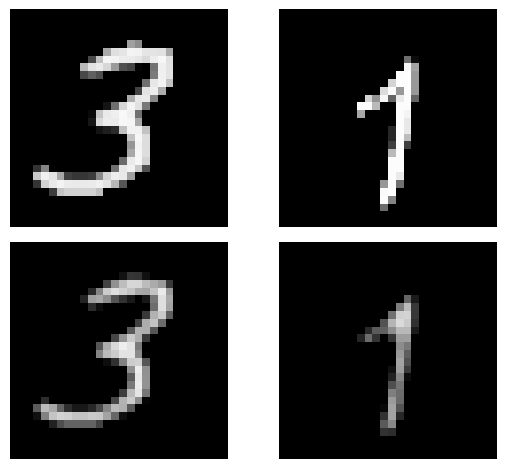

In [3]:
ssl_train_loader,lc_train_loader,test_loader= data_utils.get_dataloader(config.DATA,config.SSL["batch_size"],config.LC["batch_size"],config.INFO["num_workers"])
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))

In [4]:
ssl_model = lightning_models.CLAP(embedded_dim = config.SSL["embedded_dim"],
                                  backbone_name = config.SSL["backbone"],
                                  use_projection_header=config.SSL["use_projection_header"],
                                  proj_dim = config.SSL["proj_dim"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = config.SSL["lr"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"])

In [5]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, train_loader = ssl_train_loader,
            max_epochs=config.SSL["n_epochs"],every_n_epochs = config.SSL["update_ssl_model_every_n_epochs"],
                                        checkpoint_path=ssl_dir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model at ./simulations/ssl/last.ckpt, loading...


In [ ]:
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
ssl_model.backbone.remove_projection_header()
lc_model = lightning_models.LinearClassification(backbone = ssl_model.backbone,
                 in_dim = config.SSL["embedded_dim"],
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 lr = config.LC["lr"], 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
lc_model = lightning_models.train_lc(lc_model, lc_train_loader,test_loader,config.LC["n_epochs"],every_n_epochs=1000,checkpoint_path=lc_dir)

In [ ]:
class combined_nn(torch.nn.Module):
    def __init__(self,net1,net2):
        super().__init__()
        self.net1 = net1
        self.net2 = net2
    def forward(self,x):
        self.net1.eval()
        y = self.net1(x)
        return self.net2(y)

if config.TRAINING["training_mode"] == "new_training":
    # train the self supervised learning
    ssl_log_dir = os.path.join(config.loc,'ssl_log')
    lc_log_dir = os.path.join(config.loc,'lc_log')
    if not os.path.isdir(ssl_log_dir):
        os.makedirs(ssl_log_dir)
    if not os.path.isdir(lc_log_dir):
        os.makedirs(lc_log_dir)
    print("----------self supervised learning starts--------------")
    ssl_trainer = training_utils.model_trainer(backbone,ssl_optim,loss=ssl_loss,train_loader=ssl_train_loader,
                                        test_loader=None,val_loader=None,
                                        logdir=ssl_log_dir,is_supervised=False,device=helper.get_device())
    
    result = ssl_trainer.train_model(config.SSL["n_epoch"],20)
    save_dir = os.path.join(config.loc,config.TRAINING["save_checkpoint_dir"])
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    helper.save_checkpoint(os.path.join(save_dir,"ssl_checkpoint.pt"),backbone,ssl_optim,ssl_trainer)
    with open(os.path.join(save_dir,"ssl_training_result.json"),"w") as f:
        f.write(json.dumps(result))
    if config.SSL["use_projection_header"]:
        backbone.remove_projection_header()
   
    print("----------linear classification starts--------------")
    combine = combined_nn(backbone,linear_net)
    lc_trainer = training_utils.model_trainer(combine,lc_optim,loss=lc_loss,train_loader=lc_train_loader,
                                       test_loader=test_loader,val_loader=None,
                                       logdir=lc_log_dir,is_supervised=True,device=helper.get_device())
    result = lc_trainer.train_model(config.LC["n_epoch"],20)
    helper.save_checkpoint(os.path.join(save_dir,"lc_checkpoint.pt"),linear_net,lc_optim,lc_trainer)
    with open(os.path.join(save_dir,"lc_training_result.json"),"w") as f:
        f.write(json.dumps(result))
elif config.TRAINING["training_mode"] == "continue_training":
    # train the self supervised learning
    ssl_log_dir = os.path.join(config.loc,'ssl_log')
    ssl_trainer = training_utils.model_trainer(backbone,ssl_optim,loss=ssl_loss,train_loader=ssl_train_loader,
                                        test_loader=None,val_loader=None,
                                        logdir=ssl_log_dir,is_supervised=False,device=helper.get_device())
    load_dir = os.path.join(config.loc,config.TRAINING["load_checkpoint_dir"])
    save_dir = os.path.join(config.loc,config.TRAINING["save_checkpoint_dir"])
    backbone.to(helper.get_device())
    helper.load_checkpoint(os.path.join(load_dir,"ssl_checkpoint.pt"),backbone,ssl_optim,ssl_trainer,device=helper.get_device())
    #ssl_trainer.train_model(config.SSL["n_epoch"],20)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    helper.save_checkpoint(os.path.join(save_dir,"ssl_checkpoint.pt"),backbone,ssl_optim,ssl_trainer)
    #linear classification`weights=None
    if config.SSL["use_projection_header"]:
        backbone.remove_projection_header()
    linear_net.to(helper.get_device())
    combine = combined_nn(backbone,linear_net)
    lc_log_dir = os.path.join(config.loc,'ssl_log')
    lc_trainer = training_utils.model_trainer(combine,lc_optim,loss=lc_loss,train_loader=lc_train_loader,
                                              test_loader=test_loader,val_loader=None,
                                              logdir=lc_log_dir,is_supervised=True,device=helper.get_device())
    helper.load_checkpoint(os.path.join(load_dir,"lc_checkpoint.pt"),linear_net,lc_optim,lc_trainer,device=helper.get_device())
    result = lc_trainer.train_model(config.LC["n_epoch"],20)
    helper.save_checkpoint(os.path.join(save_dir,"lc_checkpoint.pt"),linear_net,lc_optim,lc_trainer)
    print(result)
    colors_str = ["blue","red"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for imgs,labels in test_loader:
        imgs,labels = imgs[0].to(helper.get_device()),labels[0].to(helper.get_device()) 
        v = backbone(imgs)
        print(v.shape)
        points = v.numpy(force = True)
        labels = labels.numpy(force=True).tolist()
        colors = [colors_str[l] for l in labels]
        ax.scatter(points[:,0],points[:,1],c = colors,s=0.1,alpha=0.5)


[0.44655028289678145, 0.37158200783388956, 0.362361804563172, 0.3497312257484514, 0.3633651757726864, 0.3659734303245739]


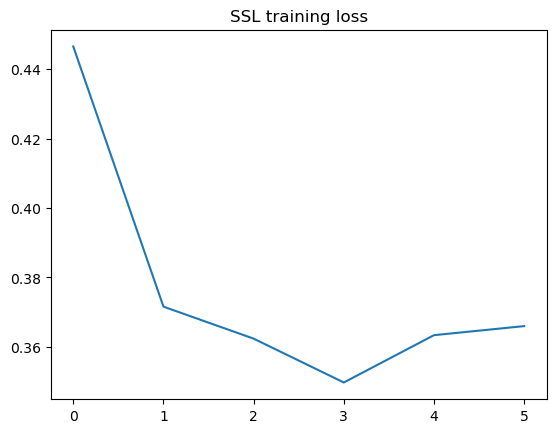

In [6]:
print(ssl_trainer.state_dict()["training_loss"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ssl_trainer.state_dict()["training_loss"])
ax.set_title("SSL training loss")
fig.savefig(os.path.join(config.loc,"ssl_trainingloss.jpg"),dpi=300)

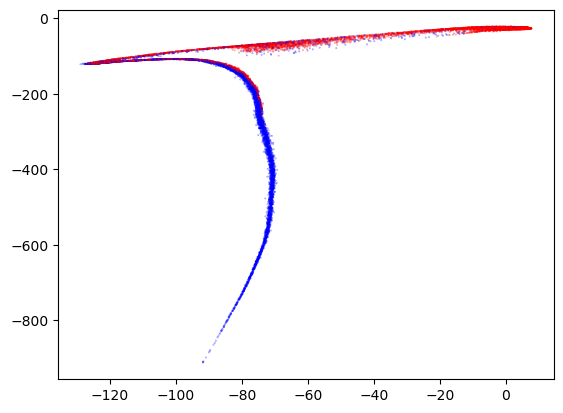

In [7]:
combine.eval()
colors_str = ["blue","red"]
fig = plt.figure()
ax = fig.add_subplot(111)
for imgs,labels in lc_train_loader:
    imgs,labels = imgs[0].to(helper.get_device()),labels[0].to(helper.get_device()) 
    v = backbone(imgs)
    points = v.numpy(force = True)
    labels = labels.numpy(force=True).tolist()
    colors = [colors_str[l] for l in labels]
    ax.scatter(points[:,0],points[:,1],c = colors,s=0.1,alpha=0.5)
fig.savefig(os.path.join(config.loc,"embedded_space.jpg"),dpi=300)

In [8]:
result

{'training_accuracy': [0.6159119606018066,
  0.7643494606018066,
  0.7991868257522583,
  0.8086734414100647,
  0.8128188848495483,
  0.8145726919174194],
 'training_loss': [0.7303550045709221,
  0.4462836202310056,
  0.3824786969593593,
  0.3878221627400846,
  0.38468353115782444,
  0.3806131171936892],
 'validation_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'validation_loss': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 'test_loss': 0.3621816635131836,
 'test_accuracy': 0.82080078125,
 'top5_accuracy': -1.0,
 'current_epoch': 6}

In [10]:
torch.cuda.device_count()

1